<a href="https://colab.research.google.com/github/clemabed/Congruence-analysis---Swiss-Citizen-Initiated-Referendum/blob/main/Congruence_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Dataset construction

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
%matplotlib inline

In [ ]:
with open('/content/stream.json') as f:  
  data = json.load(f)
df = pd.json_normalize(data['items']) 

Our columns of interest are :
  
*   institution
* categories.author_of_the_vote_object
*   date
* total_electorate
* tags *(to refine by themes)*
*   level *(subnational or national)*
* archive.recommendation *(Acceptance, Rejection or None)*
*  context.recommendation *(Acceptance, Rejection or None)*




In [ ]:
# We drop missing values with no result on referendum
df = df.dropna(subset=['result'])

**Focusing on CIR :**

In [ ]:
# We only keep CIR (either institution = Citizens' initiative or author of the vote = Citizens)

df["CIR"] = 0

for ind in df.index:
  if df['institution'][ind] == "Citizens' initiative" :
    df["CIR"][ind] = 1
  elif df['categories.author_of_the_vote_object'][ind] == "Citizens":
    df["CIR"][ind] = 1
  else:
    df["CIR"][ind] = 0

df1= df[df['CIR'] != 0] 

<ipython-input-211-e58e92606d66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CIR"][ind] = 1
<ipython-input-211-e58e92606d66>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CIR"][ind] = 0
<ipython-input-211-e58e92606d66>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CIR"][ind] = 1


**Focusing on CIR with recommendation :**

In [ ]:
# We only keep CIR with some sort of recommendation by institution


df1['context.reco'] = df1['context.recommendation'].isnull()*1
df1['archive.reco'] = df1['archive.recommendation'].isnull()*1

df1["reco"] = 0

for ind in df1.index:
  if df1['context.reco'][ind] == 0 :
    df1["reco"][ind] = df['context.recommendation'][ind]
  elif df1['archive.reco'][ind] == 0 :
    df1["reco"][ind] = df['archive.recommendation'][ind]
  else:
    df1["reco"][ind] = 0

df2 = df1[df1['reco'] != 0] 

<ipython-input-212-2ebb2d91301d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['context.reco'] = df1['context.recommendation'].isnull()*1
<ipython-input-212-2ebb2d91301d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['archive.reco'] = df1['archive.recommendation'].isnull()*1
<ipython-input-212-2ebb2d91301d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

**Final Dataset :**

In [ ]:
df3 = df2[["result", "reco", "date", "total_electorate", "question", "tags"]]
df3['results'] = (df3['result'] == 'Yes')*1
df3["recommendation"]= (df3['reco'] == 'Acceptance')*1
df3["congruence"] = abs(df3['results'] - df3["recommendation"])

# In regards with the really small frequency of "Acceptance" recommendation by government, we make the assumption
# that when institution give no recommendation 'None', it trusts citizen, it "aligns" with them
# so we count it as a 0 congruence
for ind in df3.index:
  if df3['reco'][ind] == "None" :
    df3["congruence"][ind] = 0


# Weight : total electorate divided by actual 2023 Swiss population as a first approximation
df3["weight"] = df3["total_electorate"]/ (8703000)
df3["congruence_weighted"] = df3["congruence"]*df3["weight"]
df3["year"]= df3["date"].astype(str).str[:4]
df3["compteur"] = 1

df3.head()


<ipython-input-213-0915706ad425>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['results'] = (df3['result'] == 'Yes')*1
<ipython-input-213-0915706ad425>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["recommendation"]= (df3['reco'] == 'Acceptance')*1
<ipython-input-213-0915706ad425>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,result,reco,date,total_electorate,question,tags,results,recommendation,congruence,weight,congruence_weighted,year,compteur
49,No,Rejection,2022-09-25,5549085,Wollen Sie die Volksinitiative «Keine Massenti...,"[livestock, animal protection, agriculture]",0,0,0,0.637606,0.000000,2022,1
92,Yes,Rejection,2022-02-13,5532340,"""Wollen Sie die Volksinitiative Ja zum Schutz...","[addictive substances, children and young peop...",1,0,1,0.635682,0.635682,2022,1
93,No,Rejection,2022-02-13,5532340,"""Wollen Sie die Volksinitiative Ja zum Verbot ...","[animal testing, medical research and technolo...",0,0,0,0.635682,0.000000,2022,1
109,Yes,Rejection,2021-11-28,5514490,"""Wollen Sie die Volksinitiative ""Für eine star...","[health, health policy, health and accident in...",1,0,1,0.633631,0.633631,2021,1
110,No,Rejection,2021-11-28,5514490,"""Wollen Sie die Volksinitiative ""Bestimmung de...","[courts, electoral system]",0,0,0,0.633631,0.000000,2021,1


# II. Global congruence analysis

In [ ]:
# Congruence evolution
L1 = df3.groupby(['year'])['congruence_weighted'].mean()
l1 = L1.tolist()

# CIR frequence evolution
L2 =df3.groupby(['year'])['compteur'].sum()
l2 = L2.tolist()

# List of years
L = L2.to_frame()
l = L.index
l3 = l.tolist()

In [ ]:
import matplotlib.pyplot as plt

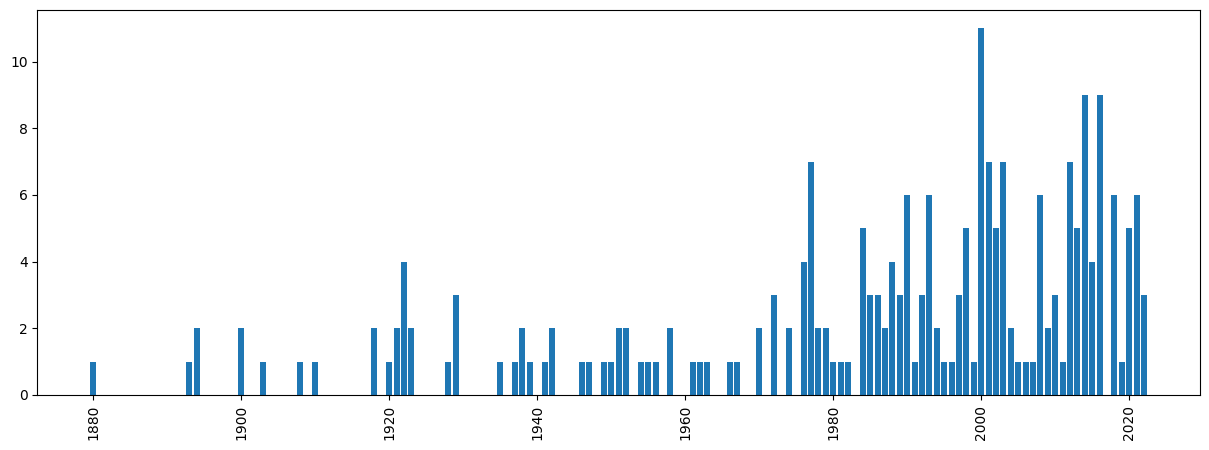

In [ ]:
# Frequency of CIR
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(l3, l2) 
plt.xticks(rotation=90)
plt.show()

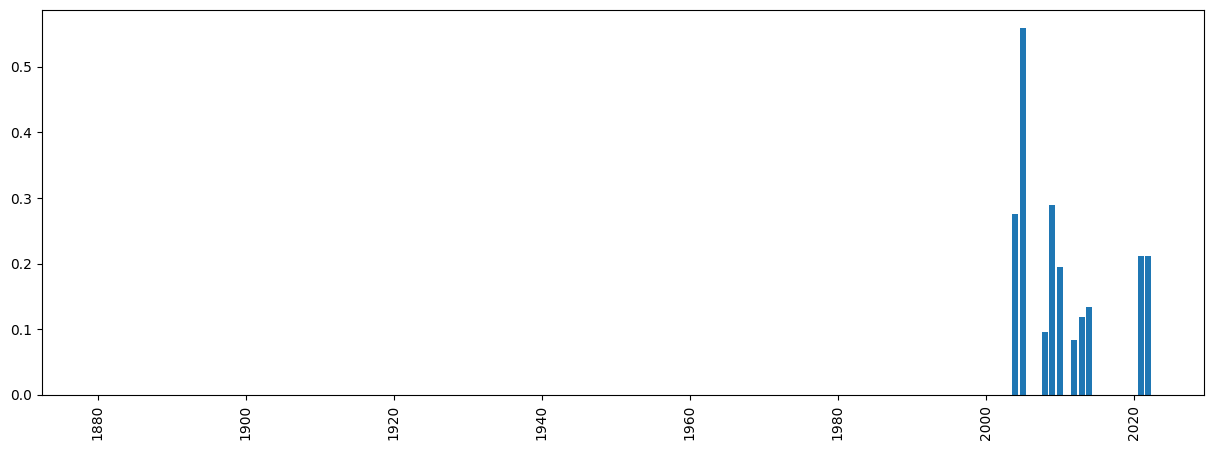

In [ ]:
# Congruence evolution
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(l3, l1) 
plt.xticks(rotation=90)
plt.show()

Many years count very few referendum. We would like to regroup window of five year to have a better homogeneity in our analysis.

In [ ]:
# Creation of 5 items sublists
lst1 = []
for i in range(0, len(l1),5):
    sub = l1[i:i + 5]
    lst1.append(sub)

print(lst1)

# Creation of frequency sublists
lst2 = []
for i in range(0, len(l2),5):
    sub = l2[i:i + 5]
    lst2.append(sub)

print(lst2)

# Creation of year subperiod 
lst3 = []
for i in range(0, len(l3),5):
    sub = l3[i:i + 5]
    lst3.append(sub)

print(lst3)

[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.27518505113179365, 0.5584472021142135, 0.0, 0.0, 0.09568780880156268], [0.2895367114788004, 0.19472415642115745, 0.0, 0.08435605127952595, 0.1189171550040216], [0.13319730105838345, 0.0, 0.0, 0.0, 0.0], [0.0, 0.21087264927802674, 0.21189398291776781]]
[[1, 1, 2, 2, 1], [1, 1, 2, 1, 2], [4, 2, 1, 3, 1], [1, 2, 1, 1, 2], [1, 1, 1, 1, 2], [2, 1, 1, 1, 2], [1, 1, 1, 1, 1], [2, 3, 2, 4, 7], [2, 2, 1, 1, 1], [5, 3, 3, 2, 4], [3, 6, 1, 3, 6], [2, 1, 1, 3, 5], [1, 11, 7, 5, 7], [2, 1, 1, 1, 6], [2, 3, 1, 7, 5], [9, 4, 9, 6, 1], [5, 6, 3]]
[[1880, 1893, 1894, 1900, 1903], [1908, 1910, 1918, 1920, 1921], [1922, 1923, 1928, 1929, 1935], [1937, 1938

In [ ]:
#del sum
#del len

In [ ]:
cong=[]
for i in lst1:
  moy = sum(i) / len(i)
  cong.append(moy)
print(cong)

freq=[]
for i in lst2:
   som = sum(i)
   freq.append(som)
print(freq)

period=[]
for i in lst3:
   deb = i[0]
   fin = i[-1]
   l = [deb, fin]
   s= " ".join(str(x) for x in l)
   period.append(s)

print(period)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18586401240951397, 0.13750681483670107, 0.02663946021167669, 0.14092221073193154]
[7, 7, 11, 7, 6, 7, 5, 18, 7, 17, 19, 12, 31, 11, 18, 29, 14]
['1880 1903', '1908 1921', '1922 1935', '1937 1942', '1946 1951', '1952 1958', '1961 1967', '1970 1977', '1978 1982', '1984 1988', '1989 1993', '1994 1998', '1999 2003', '2004 2008', '2009 2013', '2014 2019', '2020 2022']


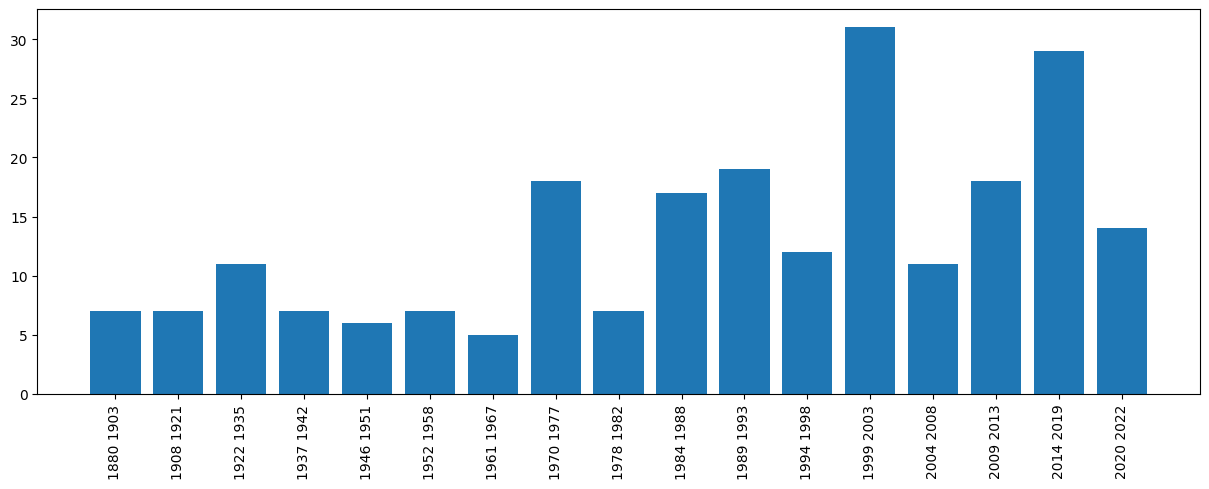

In [ ]:
# Frequency of CIR
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(period,freq) 
plt.xticks(rotation=90)
plt.show()

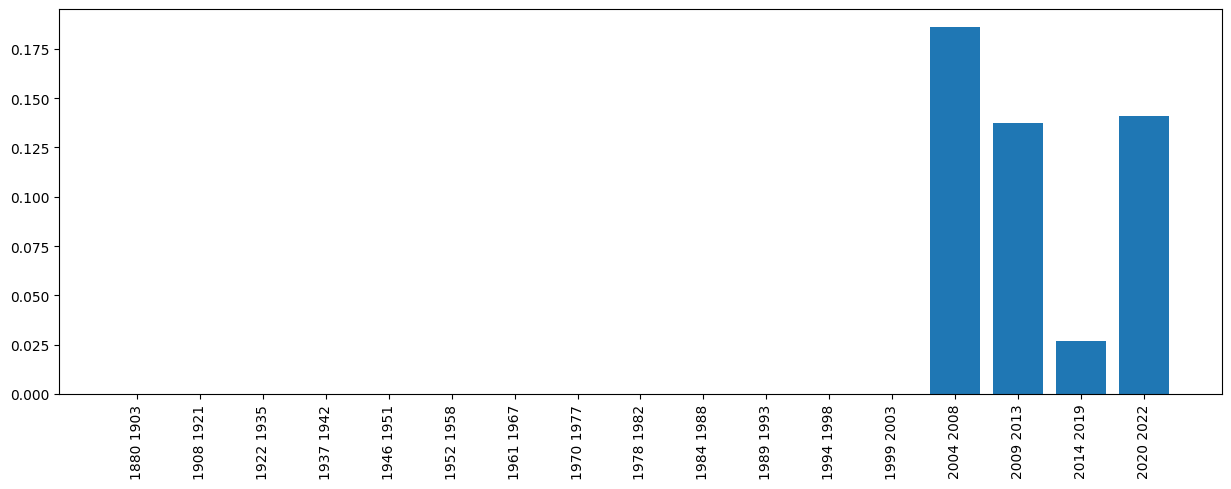

In [ ]:
# Congruence evolution
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(period,cong) 
plt.xticks(rotation=90)
plt.show()

**Refinment of analysis starting from 1990.**

We make the assumption that socio-demographic and historical context, therefore use of referendum is different before 1990.
We restrict our analysis to those years, as there are many more referendum and it coincide with a more democratized system and particpation of citizen in political life. 

In [ ]:
df3['year'] = df3['year'].astype(int)   
df4 = df3 [df3['year']> 1989]

<ipython-input-186-17de74bed775>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['year'] = df3['year'].astype(int)


In [ ]:
# Congruence evolution
Ls1 = df4.groupby(['year'])['congruence_weighted'].mean()
ls1 = Ls1.tolist()
print(ls1)
# CIR frequence evolution
Ls2 =df4.groupby(['year'])['compteur'].sum()
ls2 = Ls2.tolist()
print(ls2)
# List of years
Ls = Ls2.to_frame()
ls = Ls.index
ls3 = ls.tolist()
print(ls3)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27518505113179365, 0.5584472021142135, 0.0, 0.0, 0.09568780880156268, 0.2895367114788004, 0.19472415642115745, 0.0, 0.08435605127952595, 0.1189171550040216, 0.13319730105838345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21087264927802674, 0.21189398291776781]
[6, 1, 3, 6, 2, 1, 1, 3, 5, 1, 11, 7, 5, 7, 2, 1, 1, 1, 6, 2, 3, 1, 7, 5, 9, 4, 9, 6, 1, 5, 6, 3]
[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2018, 2019, 2020, 2021, 2022]


We decide to not consider congruence of years where there is only one referendum (not insightful)

In [ ]:
indices = [i for i, x in enumerate(ls2) if x == 1]
indices

[1, 5, 6, 9, 15, 16, 17, 21, 28]

In [ ]:
s = 0
for i in indices :
  ls2.pop(i-s)
  ls3.pop(i-s)
  ls1.pop(i-s)
  s +=1

print(ls1)
print(ls2)
print(ls3)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27518505113179365, 0.09568780880156268, 0.2895367114788004, 0.19472415642115745, 0.08435605127952595, 0.1189171550040216, 0.13319730105838345, 0.0, 0.0, 0.0, 0.0, 0.21087264927802674, 0.21189398291776781]
[6, 3, 6, 2, 3, 5, 11, 7, 5, 7, 2, 6, 2, 3, 7, 5, 9, 4, 9, 6, 5, 6, 3]
[1990, 1992, 1993, 1994, 1997, 1998, 2000, 2001, 2002, 2003, 2004, 2008, 2009, 2010, 2012, 2013, 2014, 2015, 2016, 2018, 2020, 2021, 2022]


In [ ]:
ls3 = ["1990", "1992", "1993", "1994", "1997", "1998", "2000", "2001", "2002", "2003", "2004", "2008", "2009", "2010", "2012", "2013", "2014", "2015", "2016", "2018", "2020", "2021", "2022"]

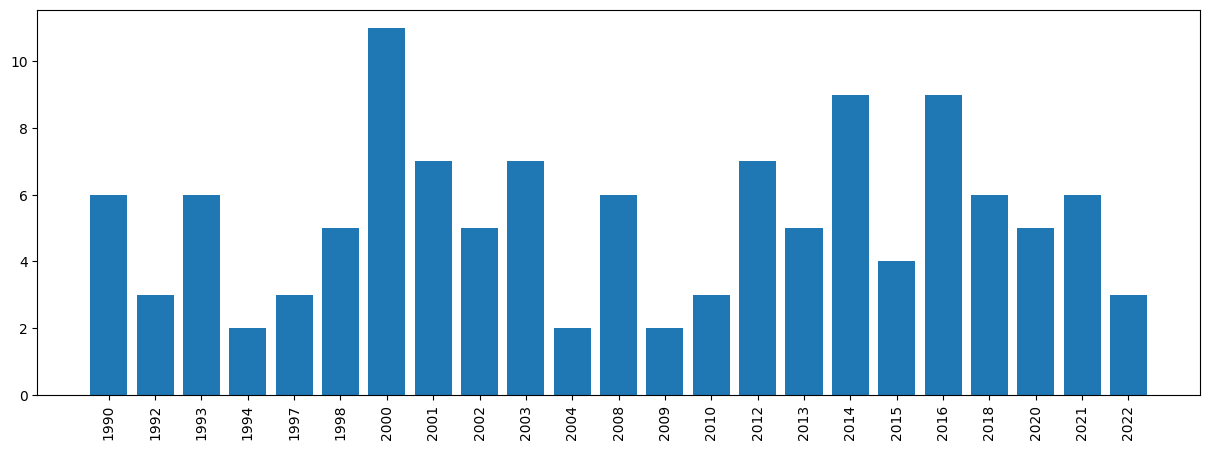

In [ ]:
# Frequency of CIR
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(ls3,ls2) 
plt.xticks(rotation=90)
plt.show()

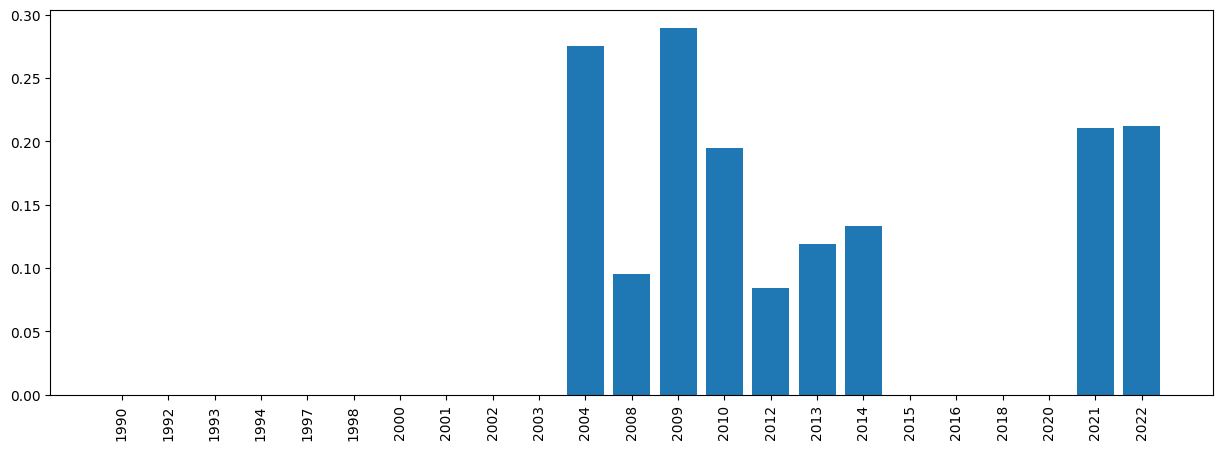

In [ ]:
# Congruence evolution
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(ls3,ls1) 
plt.xticks(rotation=90)
plt.show()

# III. Congruence per themes 

Is there more congruence for some CIR themes than for other ?
Unfortunately, due to lack of data, we only provide global measure of congruence for each themes, without accounting for time period.


In [ ]:
df3['tags']

49            [livestock, animal protection, agriculture]
92      [addictive substances, children and young peop...
93      [animal testing, medical research and technolo...
109     [health, health policy, health and accident in...
110                            [courts, electoral system]
                              ...                        
7435                       [electoral system, parliament]
7449      [intergovernmental relations, financial system]
7450    [employment policy, unemployment insurance, fu...
7452                      [livestock, religion, churches]
7470    [monetary policy, intergovernmental relations,...
Name: tags, Length: 226, dtype: object

Since we got about 200 rows, we categorize by hand into 7 themes, that we will eventually gather :

* 1 Environment
* 2 Social questions
* 3 Health
* 4 Economy policy
* 5 Employment
* 6 Swiss System
* 7 Taxation/Public Finance

In [ ]:
liste_theme = [7, 2, 5, 7, 6, 6, 6, 3, 6, 7, 6, 3, 6, 6, 2, 2, 6, 7, 6, 6, 2, 3, 1, 7, 3, 5, 6, 2, 6, 6, 6, 3, 6, 6, 5, 5, 6, 1, 7, 7, 7, 7, 1, 7, 1, 4, 5, 6, 6, 6, 3, 2, 2, 2, 7, 6, 2, 2, 3, 6, 7, 1, 5, 2, 2, 6, -1, 3, 2, 7, 1, 2, 1, 3, 1, 7, 2, 7, 6, 7, 2, 1, 1, 2, 5, 2, 3, 6, 2, 7, 6, 1, 2, 2, 5, 2, 1, 6, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 6, 3, 1, 6, 5, 3, 3, 1, 3, 2, 2, 6, 6, 2, 1, 6, 2, 2, 3, 7, 6, 6, 3, 1, 2, 6, 1, 2, 2, 6, 3, 6, 3, 1, 7, 6, 6, 7, 6, 5, 2, 7, 5, -1, 7, 3, 2, 1, 1, 5, 6, -1, 1, 7, 3, 3, 6, 6, 6, 7, 1, 3, 6, 2, 1, 2, 7, 6, 1, 7, 3, 7, 6, 7, 3, 4, 6, 6, 5, 7, 3, 2, 6, 5, 4, 2, 7, 1, 4, 7, 7, 2, 7, 2, 6, 4, -1, 2, 7, 1, 2, 1, -1, 7, 1, 4, 1, 6, 1, 2, 2, 6, 6, 7, 2, 1, 1, 7, 6, 2, 2, 2, 1]

In [ ]:
len(liste_theme)

231

In [ ]:
liste_theme.reverse()
df3['theme'] = liste_theme

df5 = df3[df3['theme'] != -1]

<ipython-input-202-40dab6b206f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['theme'] = liste_theme


We gather theme 4 and 5 since there are very few CIR on those topics.

In [ ]:
for ind in df5.index:
  if df5['theme'][ind] == 5 :
    df5["theme"][ind] = 4

<ipython-input-203-5d50cb18ad85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5["theme"][ind] = 4


In [ ]:
# Congruence by theme
L_1 = df5.groupby(['theme'])['congruence_weighted'].mean()
l_1 = L_1.tolist()
print(l_1)
# CIR frequence by theme
L_2 = df5.groupby(['theme'])['compteur'].sum()
l_2 = L_2.tolist()
print(l_2)
# List of years
L_3 = L_2.to_frame()
l_3 = L_3.index
l_3 = l_3.tolist()
print(l_3)


[0.028723489026772374, 0.07962982030184494, 0.0, 0.0297292887510054, 0.03135390304283789, 0.0]
[40, 46, 28, 20, 55, 37]
[1, 2, 3, 4, 6, 7]


In [ ]:
l = ['Environment', "Social Issue","Health", "Eco/Employment", "System", "Public Finance"]

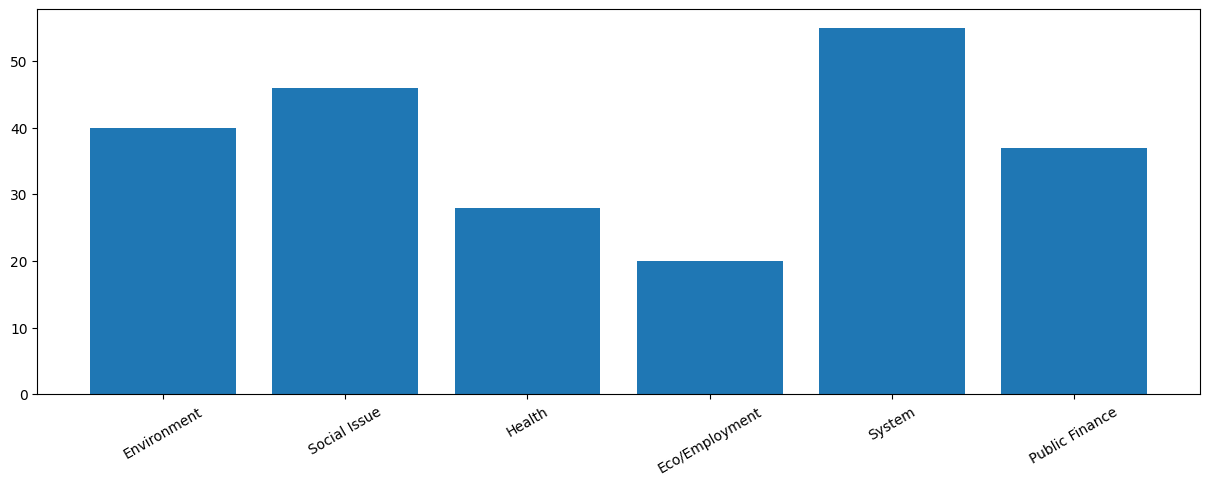

In [ ]:
# Frequency by theme
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(l,l_2) 
plt.xticks(rotation=30)
plt.show()

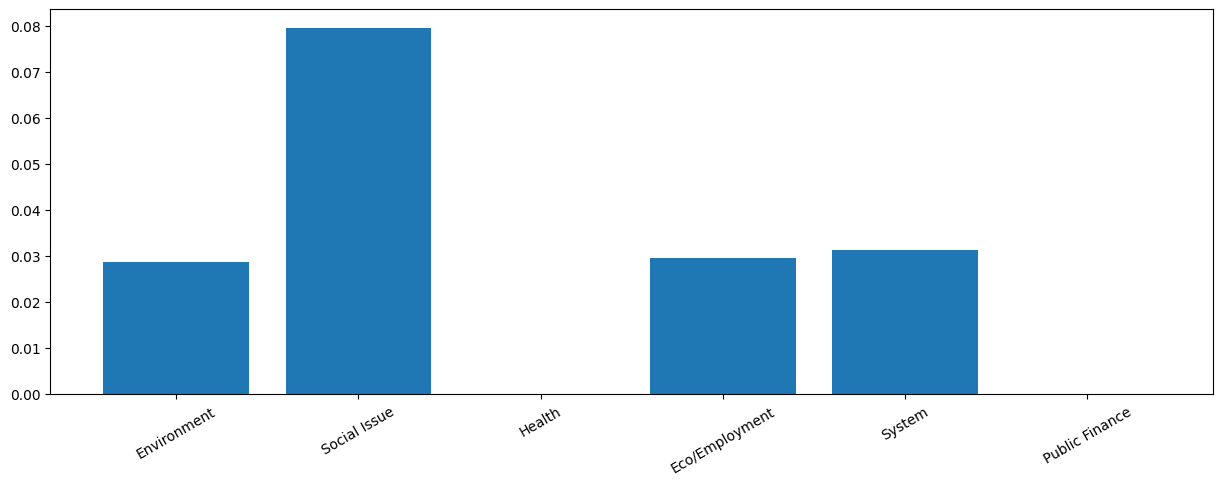

In [ ]:
# Congruence by theme
fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(l,l_1) 
plt.xticks(rotation=30)
plt.show()